In [56]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [57]:
def trim(im) :
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im,bg)
    diff = PIL.ImageChops.add(diff,diff,2.0,-20)
    bbox = diff.getbbox()
    if bbox :
        return im.crop(bbox)

def img_preprocessing(img) :
    img = trim(img)
    img = img.resize(128,128)
    img = img.convert('L')
    
## 위에 과정은 resize, gray scale 사용할거면 필요 없음. 
## 이미지 전처리하는 과정인데 전처리해서 grayscale로 만들지를 않음. 

In [58]:
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(3)

#1 데이터 전처리 -> ImageDataGenerator 사용! 
train_datagen = ImageDataGenerator(rescale=1./255)  
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('retinopathy_dataset_resize_gray/train',
                                                 target_size = (128,128),
                                                 batch_size = 64,
                                                 class_mode = 'binary')

test_generator = test_datagen.flow_from_directory('retinopathy_dataset_resize_gray/test',
                                            target_size = (128,128),
                                            batch_size = 64,
                                            class_mode = 'binary')

Found 1230 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


In [94]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
import numpy as np


model = Sequential()
model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #(64,64)
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #(32,32)
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #(16,16)
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #(8,8)
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #(4,4)
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) 
# sigmoid로 간 이유 https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/
# softmax로 가면 loss funcion에서 문제가 생김. 




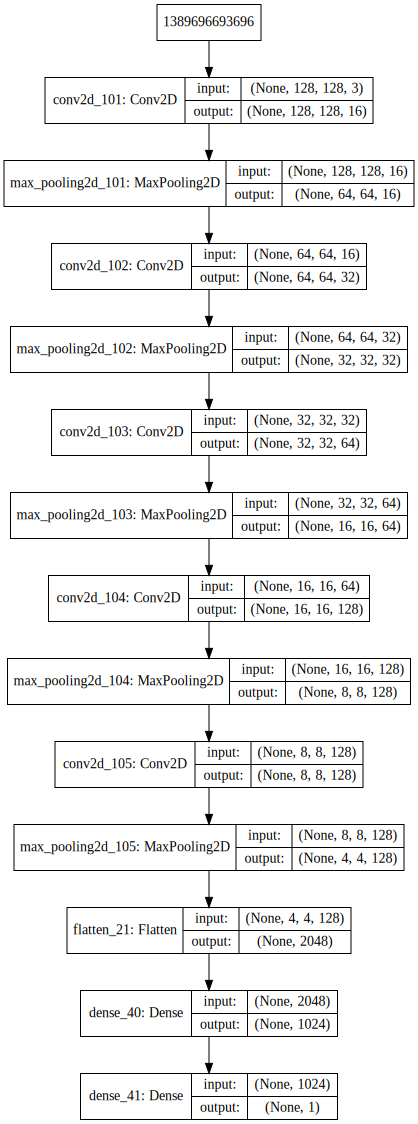

In [89]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [95]:
#모델 학습과정 설정 및 모델 학습
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의

hist= model.fit_generator(
    train_generator,
    steps_per_epoch=20,#1230 data에 batch_size=64 1230/64=19.21875 ->20
    epochs=30, # 최적화를 위해 5번의 epoch를  30번으로 늘림. 
    validation_data=test_generator,
    validation_steps=5,  #292 data의 batch_size 64 292/64 =4.5625 -> 5
    callbacks=[early_stopping]) 

Epoch 1/30
20/20 [==============================] - 37s 2s/step - loss: 0.6963 - acc: 0.4984 - val_loss: 0.6939 - val_acc: 0.4932
Epoch 2/30
20/20 [==============================] - 33s 2s/step - loss: 0.6934 - acc: 0.5077 - val_loss: 0.6934 - val_acc: 0.4932
Epoch 3/30
20/20 [==============================] - 33s 2s/step - loss: 0.6932 - acc: 0.4923 - val_loss: 0.6919 - val_acc: 0.5274
Epoch 4/30
20/20 [==============================] - 33s 2s/step - loss: 0.6929 - acc: 0.5033 - val_loss: 0.6917 - val_acc: 0.5274
Epoch 5/30
20/20 [==============================] - 34s 2s/step - loss: 0.6926 - acc: 0.5288 - val_loss: 0.6941 - val_acc: 0.4863
Epoch 6/30
20/20 [==============================] - 33s 2s/step - loss: 0.6900 - acc: 0.5427 - val_loss: 0.7001 - val_acc: 0.4829
Epoch 7/30
20/20 [==============================] - 33s 2s/step - loss: 0.6849 - acc: 0.5700 - val_loss: 0.6854 - val_acc: 0.5548
Epoch 8/30
20/20 [==============================] - 32s 2s/step - loss: 0.6788 - acc: 0.57

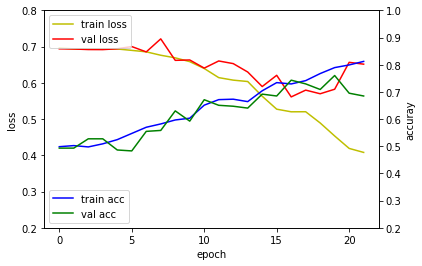

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.2, 0.8])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.2, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [97]:
# 모델 평가하기
print("-- Evaluate --")
test_pred = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], test_pred[1]*100))

-- Evaluate --
acc: 68.49%


In [98]:
# 모델 사용하기
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
print(test_generator.class_indices)
print(output)

-- Predict --
{'0': 0, '1': 1}
[[0.374]
 [0.894]
 [0.984]
 [0.640]
 [0.628]
 [0.826]
 [0.835]
 [0.667]
 [0.924]
 [0.037]
 [0.922]
 [0.116]
 [0.850]
 [0.853]
 [0.436]
 [0.638]
 [0.533]
 [0.741]
 [0.519]
 [0.010]
 [0.507]
 [0.238]
 [0.657]
 [0.222]
 [0.118]
 [0.118]
 [0.695]
 [0.341]
 [0.884]
 [0.562]
 [0.791]
 [0.282]
 [0.689]
 [0.805]
 [0.273]
 [0.920]
 [0.971]
 [0.996]
 [0.720]
 [0.409]
 [0.849]
 [0.967]
 [0.378]
 [0.486]
 [0.508]
 [0.321]
 [0.975]
 [0.891]
 [0.967]
 [0.287]
 [0.748]
 [0.826]
 [0.856]
 [0.676]
 [0.949]
 [0.841]
 [0.908]
 [0.455]
 [0.301]
 [0.530]
 [0.410]
 [0.039]
 [0.847]
 [0.333]
 [0.822]
 [0.958]
 [0.192]
 [0.021]
 [0.442]
 [0.262]
 [0.948]
 [0.595]
 [0.900]
 [0.748]
 [0.750]
 [0.952]
 [0.871]
 [0.873]
 [0.866]
 [0.846]
 [0.871]
 [0.077]
 [0.114]
 [0.934]
 [0.004]
 [0.466]
 [0.138]
 [0.579]
 [0.831]
 [0.680]
 [0.450]
 [0.050]
 [0.901]
 [0.214]
 [1.000]
 [0.031]
 [0.310]
 [0.063]
 [0.860]
 [0.991]
 [0.100]
 [0.463]
 [0.087]
 [0.356]
 [0.122]
 [0.256]
 [0.332]
 [0.88